In [1]:
import os
import numpy as np
import pyccl as ccl
import healpy as hp
import matplotlib.pyplot as plt
from scipy.integrate import simps
from astropy.io import fits

### View density grids

Ngrid = 256
Lbox = 1000.000 Mpc/h


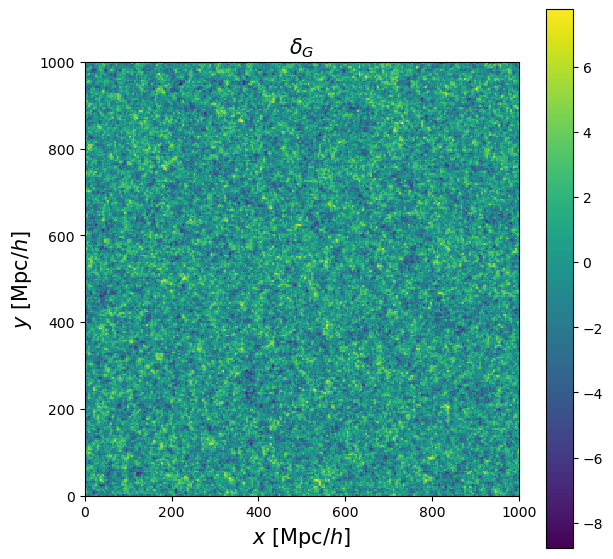

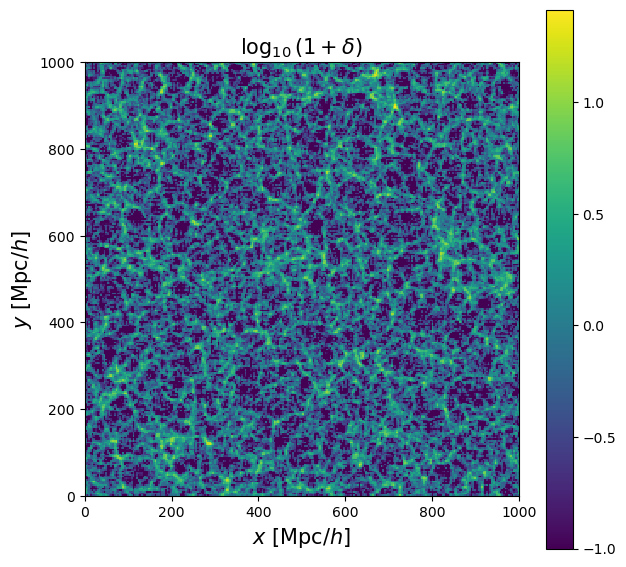

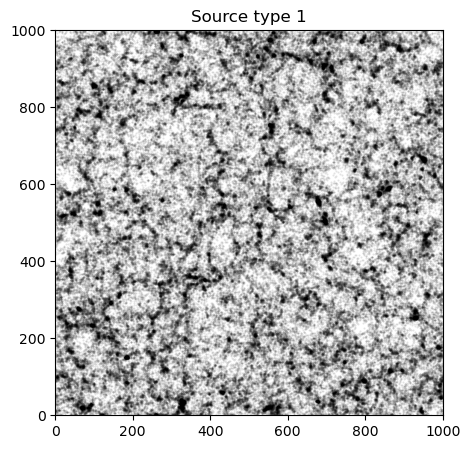

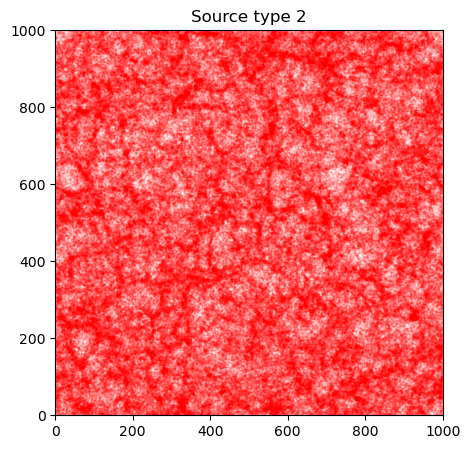

In [2]:
def read_grid(prefix):
    # This routine reads a 3D grid in CoLoRe's native format
    f = open(prefix+"_0.dat", "rb")
    nfiles, size_float = np.fromfile(f, dtype=np.int32, count=2)
    lbox = np.fromfile(f, dtype=np.float64, count=1)[0]
    ngrid = np.fromfile(f, dtype=np.int32, count=1)[0]
    f.close()

    if size_float == 4:
        f_type = np.float32
    else:
        f_type = np.float64

    grid_out = np.zeros([ngrid, ngrid, ngrid])
    for ifil in np.arange(nfiles):
        f = open(prefix+"_%d.dat" % ifil, "rb")
        nf, sz = np.fromfile(f, dtype=np.int32, count=2)
        _ = np.fromfile(f, dtype=np.float64, count=1)
        ng, nz_here, iz0_here = np.fromfile(f, dtype=np.int32, count=3)
        for iz in np.arange(nz_here):
            d = np.fromfile(f, dtype=f_type, count=ng*ng).reshape([ng, ng])
            grid_out[iz0_here+iz, :, :] = d
        f.close()

    return ngrid, lbox, np.array(grid_out)

# Read Gaussian field and non-linear field
ng, lb, dens = read_grid('colore_out_dens_nonlinear')
_, _, densG = read_grid('colore_out_dens_gaussian')
print("Ngrid = %d" % ng)
print("Lbox = %.3lf Mpc/h" % lb)


plt.figure(figsize=(7, 7))
plt.title(r'$\delta_G$', fontsize=15)
plt.imshow(densG[:, :, ng//2], origin='lower',
           interpolation='nearest',
           extent=[0, lb, 0, lb])
plt.colorbar()
plt.xlabel(r'$x\,\,[{\rm Mpc}/h]$', fontsize=15)
plt.ylabel(r'$y\,\,[{\rm Mpc}/h]$', fontsize=15);

plt.figure(figsize=(7, 7))
plt.title(r'$\log_{10}(1+\delta)$', fontsize=15)
plt.imshow(np.log10(1.001+dens[:, :, ng//2]),
           origin='lower',
           interpolation='nearest',
           vmin=-1, extent=[0, lb, 0, lb])
plt.colorbar()
plt.xlabel(r'$x\,\,[{\rm Mpc}/h]$', fontsize=15)
plt.ylabel(r'$y\,\,[{\rm Mpc}/h]$', fontsize=15)

# Read each catalog, select sources in a slab around
# the middle of the box, and plot them.
# They should track the same structures seen in the
# non-linear field.
for src, col in zip([1, 2], ['k', 'r']):
    cat = fits.open(f"colore_out_srcs_s{src}_0.fits")[1].data
    igood = (cat['x']-lb/2 < lb/20) & (cat['x']-lb/2 > -lb/20)
    plt.figure(figsize=(5, 5))
    plt.title(f"Source type {src}")
    plt.plot(cat[igood]['y'], cat[igood]['z'], col+'.', ms=1, alpha=0.1)
    plt.xlim([0, lb])
    plt.ylim([0, lb])

### Calculate $P(k)$
Ignoring RSDs first

Text(0, 0.5, '$P(k)\\,\\,[({\\rm Mpc}\\,h^{-1})^3]$')

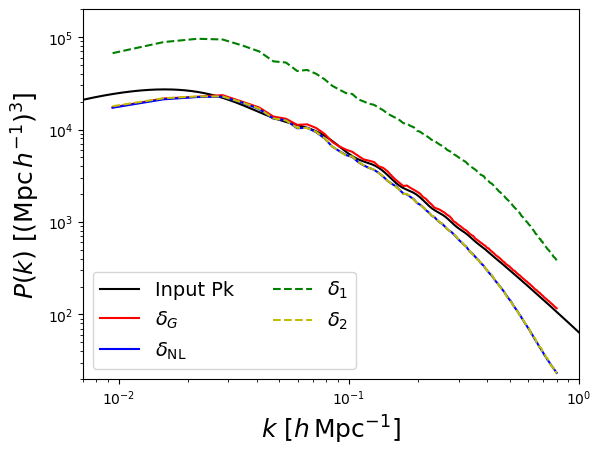

In [3]:
def cat2delta(cat, lbox, ngrid, w_rsd=False):
    # Gets overdensity grid from a catalog
    ix = np.floor((cat['x']+cat['dx_rsd']*w_rsd)*ngrid/lbox).astype(int)
    iy = np.floor(cat['y']*ngrid/lbox).astype(int)
    iz = np.floor(cat['z']*ngrid/lbox).astype(int)
    ix[ix >= ngrid] -= ngrid
    ix[ix < 0] += ngrid
    iy[iy >= ngrid] -= ngrid
    iy[iy < 0] += ngrid
    iz[iz >= ngrid] -= ngrid
    iz[iz < 0] += ngrid
    ind = ix + ngrid*(iy + ngrid*iz)
    n = np.bincount(ind, minlength=ngrid**3)
    nmean = len(cat)/ngrid**3
    delt = n/nmean-1
    return delt.reshape([ngrid, ngrid, ngrid])


def get_pk(grid, lbox, ngrid, cat=None, ell=0):
    # Computes power spectrum from an overdensity grid

    # FFT
    dk = np.fft.rfftn(grid)*(lbox/ngrid)**3

    # k sampling
    kfull = np.fft.fftfreq(ngrid, d=lbox/ngrid)*2*np.pi
    khalf = np.fft.rfftfreq(ngrid, d=lbox/ngrid)*2*np.pi

    # P(k) estimator
    ks = np.sqrt(kfull[:, None, None]**2+kfull[None, :, None]**2+khalf[None, None, :]**2)
    if ell==0:
        wmu = 1
    else:
        mu = khalf[None, None, :]/(ks+1E-7) # Avoid division by zero
        if ell==2:
            wmu = 0.5*(3*mu**2-1)
        elif ell==4:
            wmu = 0.125*(35*mu**4-30*mu**2+3)
    sm, kb = np.histogram(ks.flatten(), bins=ngrid//2, range=[0, ngrid*np.pi/lbox],
                          weights=(np.real(dk*np.conjugate(dk))*wmu).flatten())
    ncell, _ = np.histogram(ks.flatten(), bins=ngrid//2, range=[0, ngrid*np.pi/lbox])
    pk = (2*ell+1)*sm/(ncell*lbox**3)
    km = 0.5*(kb[1:]+kb[:-1])

    # Remove shot noise if needed
    if (cat is not None) and (ell == 0):
        sn = lbox**3/len(cat)
        pk -= sn
    return kb, km, pk


# Input power spectrum
kk, pkk = np.loadtxt('pk.dat', unpack=True)
plt.plot(kk, pkk, 'k-', label='Input Pk')

# P(k) of the Gaussian overdensity
x_, km, pk = get_pk(densG, lb, ng)
plt.plot(km[1:], pk[1:], 'r-', label=r'$\delta_G$')

# P(k) of the non-linear overdensity
_, km, pk = get_pk(dens, lb, ng)
plt.plot(km[1:], pk[1:], 'b-', label=r'$\delta_{\rm NL}$')

# P(k) of each galaxy sample
for src, col, bias in zip([1, 2], ['g', 'y'], [2, 1]):
    cat = fits.open(f"colore_out_srcs_s{src}_0.fits")[1].data
    d = cat2delta(cat, lb, ng)
    _, km, pk = get_pk(d, lb, ng, cat=cat)
    plt.plot(km[1:], pk[1:], col+'--', label=f'$\\delta_{src}$')

plt.loglog()
plt.xlim([7E-3, 1])
plt.ylim([2E1, 2E5])
plt.legend(fontsize=14, ncol=2)
plt.xlabel(r'$k\,\,[h\,{\rm Mpc}^{-1}]$', fontsize=18)
plt.ylabel(r'$P(k)\,\,[({\rm Mpc}\,h^{-1})^3]$', fontsize=18)

### Include RSDs
Below we compute the power spectrum multipoles in the presence of RSDs, and correct for the corresponding factors of $b$ and $\beta$ that would make them match the matter power spectrum in the Kaiser limit.

Text(0, 0.5, '$P(k)\\,\\,[({\\rm Mpc}\\,h^{-1})^3]$')

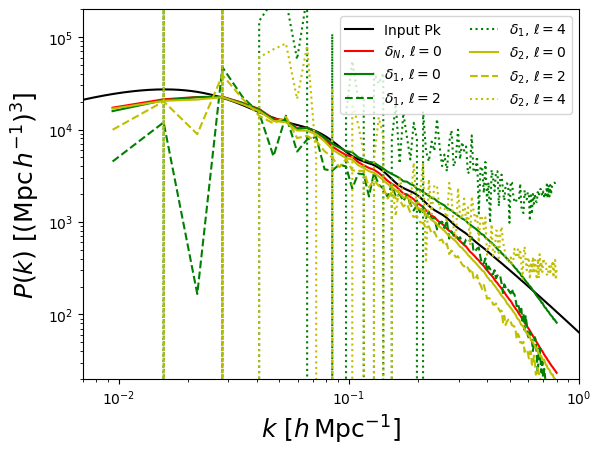

In [4]:
# Growht rate at z=0
f0 = 0.513
def fbeta(b, ell):
    beta = f0/b
    if ell == 0:
        return b**2*(1+2*beta/3+beta**2/5)
    elif ell == 2:
        return b**2*(4*beta/3+4*beta**2/7)
    elif ell == 4:
        return b**2*8*beta**2/35

# Input power spectrum
kk, pkk = np.loadtxt('pk.dat', unpack=True)
plt.plot(kk, pkk, 'k-', label='Input Pk')

# P(k) of the Nonlinear overdensity
for ell, ls in zip([0], ['-', '--', ':']):
    x_, km, pk0 = get_pk(dens, lb, ng, ell=ell)
    plt.plot(km[1:], pk0[1:], 'r'+ls, label=f'$\\delta_N,\\,\\ell={ell}$')

# P(k) of each galaxy sample
for src, col, bias in zip([1, 2], ['g', 'y'], [2, 1]):
    cat = fits.open(f"colore_out_srcs_s{src}_0.fits")[1].data
    d = cat2delta(cat, lb, ng, w_rsd=True)
    for ell, ls in zip([0, 2, 4], ['-', '--', ':']):
        _, km, pk = get_pk(d, lb, ng, cat=cat, ell=ell)
        fb = fbeta(bias, ell)
        plt.plot(km[1:], pk[1:]/fb, col+ls, label=f'$\\delta_{src},\\,\\ell={ell}$')

plt.loglog()
plt.xlim([7E-3, 1])
plt.ylim([2E1, 2E5])
plt.legend(fontsize=10, ncol=2, loc='upper right')
plt.xlabel(r'$k\,\,[h\,{\rm Mpc}^{-1}]$', fontsize=18)
plt.ylabel(r'$P(k)\,\,[({\rm Mpc}\,h^{-1})^3]$', fontsize=18)